# Barotropic tides: medsea FES

[pyTMD tutorials](https://pytmd.readthedocs.io/en/latest/user_guide/Examples.html)

Link to [FES data](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)


In [1]:
import os

import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec

import pynsitu as pin
crs = pin.maps.crs
import pynsitu.tides as td

---

## harmonic amplitudes in the area of interest

In [2]:
# output 2d grid
extent = [5, 6.8, 42, 43.2]
dl_min = 0.0625 # potential resolution: 0.0625

# atlantic - check
#extent = [-40, 10, 30, 55]
#dl_min = 0.5 # potential resolution: 0.0625

plot_map = lambda: pin.maps.plot_map(extent=extent, coastline="10m")

lon, lat = (extent[0], extent[1], dl_min), (extent[2], extent[3], dl_min) # cp area

In [3]:
# load 
def load_bathy():
    from pyproj import Transformer
    transformer = Transformer.from_crs("EPSG:2154", "EPSG:4326")

    csv = "Interpolation_bathymetry_LSPM_cable.csv"
    ds = pd.read_csv(csv).to_xarray()
    lat, lon = transformer.transform(ds.X, ds.Y)
    ds["lon"] = ("index", lon)
    ds["lat"] = ("index", lat)

    ds["depth"] = -ds["Z"]
    ds["dl"] = np.sqrt( (ds["X"].shift(index=-1)-ds["X"])**2 + (ds["Y"].shift(index=-1)-ds["Y"])**2 )

    ds = ds.rename(index="position")
    return ds

cable = load_bathy()

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 2.3098e+04]),
 array([0.52233706, 0.70020224, 0.87806742, 1.0559326 , 1.23379779,
        1.41166297, 1.58952815, 1.76739334, 1.94525852, 2.1231237 ,
        2.30098888]),
 <BarContainer object of 10 artists>)

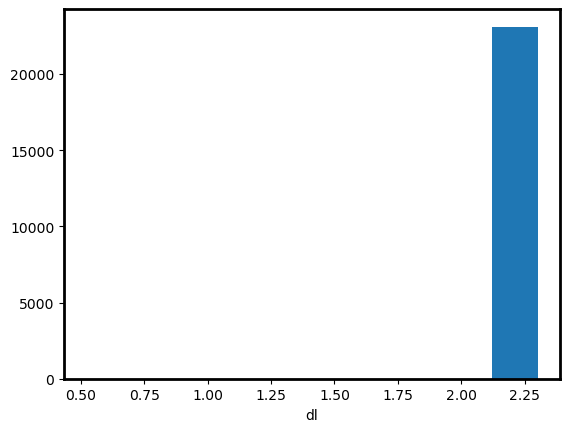

In [4]:
cable.dl.plot.hist()

In [5]:
# coarsen cable position: 2m -> 20m
cable_coarse = cable.coarsen(position=10, boundary="trim").mean()

#fig, ax, _ = plot_map()
#ax.scatter(cable_coarse.lon, cable_coarse.lat, c=cable_coarse.depth, s=10, transform=crs)

cable_coarse

<xarray.Dataset> Size: 185kB
Dimensions:   (position: 2311)
Coordinates:
  * position  (position) float64 18kB 4.5 14.5 24.5 ... 2.309e+04 2.31e+04
Data variables:
    X         (position) float64 18kB 9.362e+05 9.362e+05 ... 9.442e+05
    Y         (position) float64 18kB 6.225e+06 6.225e+06 ... 6.194e+06
    Z         (position) float64 18kB -0.8094 -0.8094 ... -2.421e+03 -2.422e+03
    distance  (position) float64 18kB 10.35 33.35 56.35 ... 5.312e+04 5.314e+04
    angle     (position) float64 18kB 190.7 201.4 201.4 ... 252.1 252.1 252.1
    lon       (position) float64 18kB 5.899 5.899 5.899 ... 5.984 5.983 5.983
    lat       (position) float64 18kB 43.09 43.09 43.09 43.09 ... 42.8 42.8 42.8
    depth     (position) float64 18kB 0.8094 0.8094 ... 2.421e+03 2.422e+03
    dl        (position) float64 18kB 2.299 2.3 2.3 2.3 2.3 ... 2.3 2.3 2.3 2.3

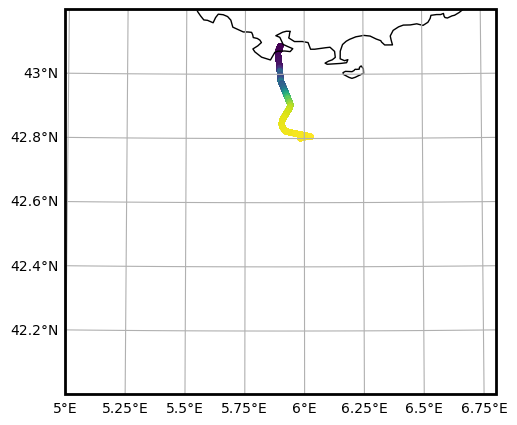

In [6]:
fig, ax, _ = plot_map()
ax.scatter(cable.lon, cable.lat, c=cable.depth, s=10, transform=crs)

In [27]:
# load sea level and semi-diurnal constituents only
vtype = ["z", "load"]
csts = td.major_semidiurnal + td.major_diurnal
ds_2d = td.load_tidal_amplitudes(lon, lat, vtype, constituents=csts)
#ds_moorings = td.load_tidal_amplitudes(mo.lon, mo.lat, vtype, constituents=csts)

broadcasting lon/lat
broadcasting lon/lat


In [43]:

def plot_amplitude(ds, c, v):

    dt1 = 1/360*2*np.pi/pin.tides.cproperties.loc[c, "omega"]

    #
    fig, ax, _ = plot_map()
    _ds = ds_2d.sel(constituent=c)
    
    (
        np.abs(_ds[v+"_amplitude"])
        .rename("abs(amplitude)")
        .plot(
         x="lon", y="lat",
         #vmin=vmin,vmax=vmax,
         ax=ax, transform=crs,
        )
    )
    ax.set_title(f"{c} {v} tide - amplitude")

    #
    fig, ax, _ = plot_map()
    phase = xr.DataArray(
        np.rad2deg(np.angle(_ds[v+"_amplitude"])), 
        coords=ds_2d.sel(constituent=c).coords,
    )
    (
        phase
        .rename("phase")
        .plot(
            x="lon", y="lat",
             #vmin=vmin,vmax=vmax,
             ax=ax, transform=crs,
        )
    )

    ax.set_title(f"{c} {v} tide - phase, 1 deg = {dt1/60:.1f}min")


c = "m2"
#plot_amplitude(ds_2d, c, "load")
#plot_amplitude(ds_2d, c, "z")

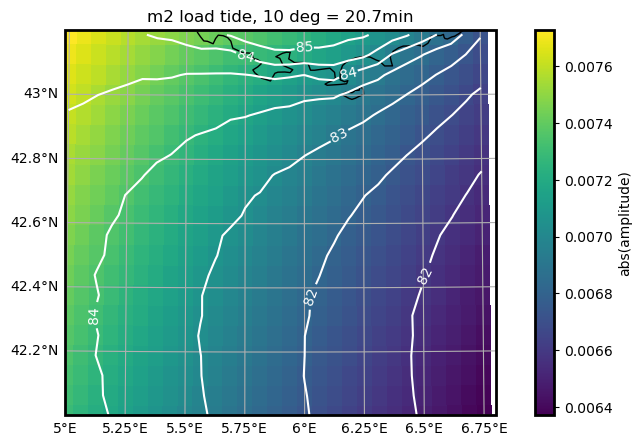

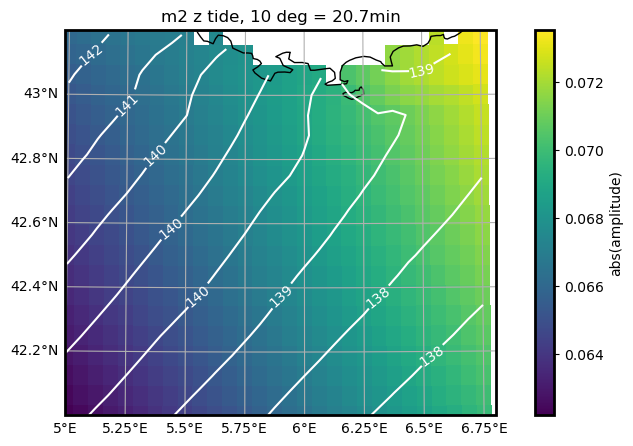

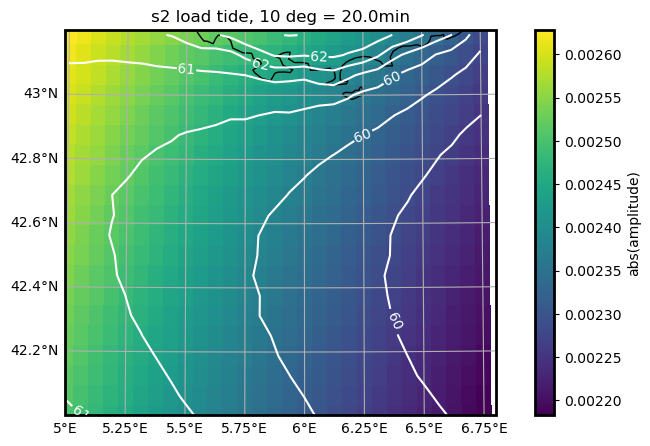

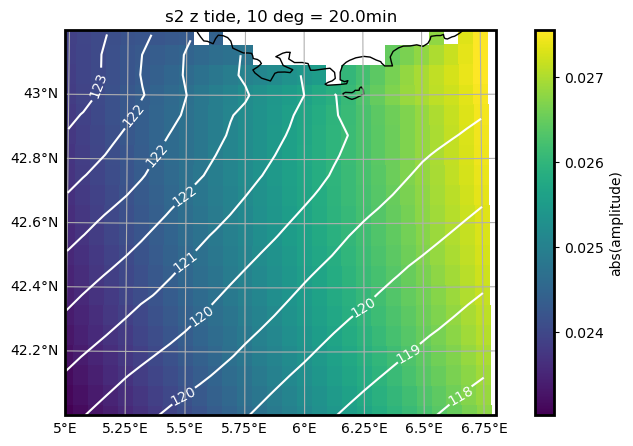

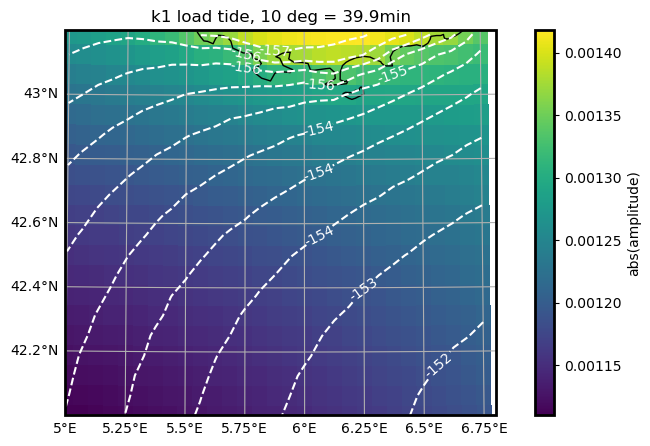

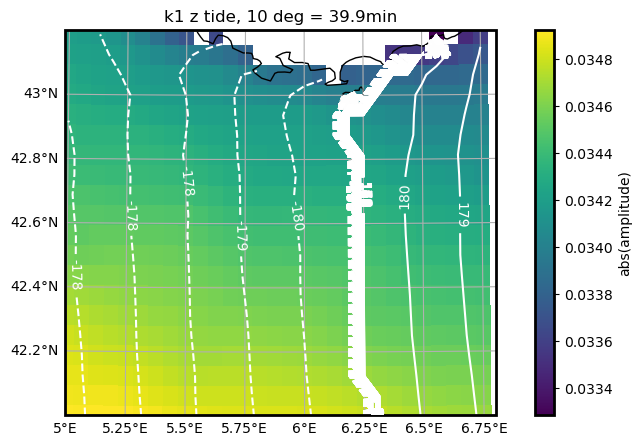

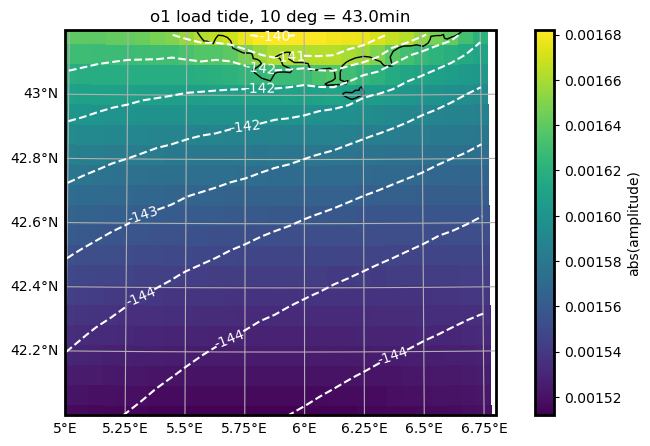

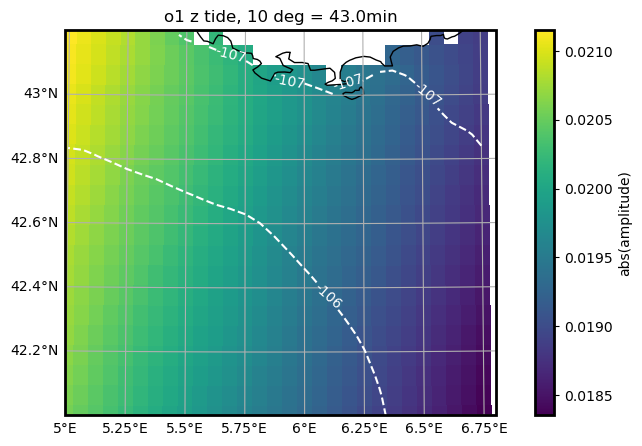

In [29]:
def plot_amplitude_ctr(ds, c, v, dphi=.5):

    dt1 = 1/360*2*np.pi/pin.tides.cproperties.loc[c, "omega"]
    dt10 = dt1*10

    fig, ax, _ = plot_map()
    
    _ds = ds_2d.sel(constituent=c)
    
    (
        np.abs(_ds[v+"_amplitude"])
        .rename("abs(amplitude)")
        .plot(
         x="lon", y="lat",
         #vmin=vmin,vmax=vmax,
         ax=ax, transform=crs,
        )
    )
    
    
    phase = xr.DataArray(
        np.rad2deg(np.angle(_ds[v+"_amplitude"])), 
        coords=ds_2d.sel(constituent=c).coords,
    )
    CS = (
        phase
        .rename("phase")
        .plot.contour(
            x="lon", y="lat",
            levels=np.arange(-180,180,dphi),
            colors="w",
             #vmin=vmin,vmax=vmax,
             ax=ax, transform=crs,
        )
    )
    fmt = lambda x: f"{x:.0f}"
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

    ax.set_title(f"{c} {v} tide, 10 deg = {dt10/60:.1f}min")
    
    if False:
        _ds = ds_moorings.sel(constituent=c)
        h = ax.scatter(
            _ds.lon, _ds.lat, c=np.abs(_ds[vtype+"_amplitude"]), 
            s=200, edgecolors="orange", marker="*",
            #_ds.lon, _ds.lat, c="w", s=100, edgecolors="0.5",
            vmin=vmin,vmax=vmax,
            transform=crs,
            zorder=10,
        )



dphi = .5
#dphi = 10
for c in csts:
    plot_amplitude_ctr(ds_2d, c, "load", dphi=dphi)
    plot_amplitude_ctr(ds_2d, c, "z", dphi=dphi)

### store all tidal harmonics

In [10]:
prod = True
#prod = False

nc = "meust_cable_tidal_harmonics.nc"
if prod:
    ha = td.load_raw_tidal_amplitudes(["z", "body", "u", "v"], lon=lon, lat=lat)
    ha.to_netcdf(nc, mode="w")
else:
    ha = xr.open_dataset(nc)

---

## tidal predictions

### just sea level and (m2, s2)

In [7]:
#time = pd.date_range("2023/04/01", "2023/12/01", freq="20min")
time = pd.date_range("2023/10/20", "2023/11/15", freq="20min")

In [26]:
# just m2 and s2
ds = td.tidal_prediction(cable_coarse.lon, cable_coarse.lat, time, ["load"], constituents=td.major_semidiurnal, minor=False, split=True)
ds

<xarray.Dataset> Size: 975MB
Dimensions:          (position: 2311, time: 17569, constituent: 2)
Coordinates:
  * position         (position) float64 18kB 4.5 14.5 ... 2.309e+04 2.31e+04
  * constituent      (constituent) object 16B 'm2' 's2'
    amplitude        (constituent) float64 16B 0.2441 0.1127
    phase            (constituent) float64 16B 1.732 0.0
    omega            (constituent) float64 16B 0.0001405 0.0001454
    alpha            (constituent) float64 16B 0.693 0.693
    species          (constituent) float64 16B 2.0 2.0
    omega_cpd        (constituent) float64 16B 1.932 2.0
  * time             (time) datetime64[ns] 141kB 2023-04-01 ... 2023-12-01
Data variables:
    lon              (position) float64 18kB 5.899 5.899 5.899 ... 5.983 5.983
    lat              (position) float64 18kB 43.09 43.09 43.09 ... 42.8 42.8
    load_tide        (position, time) float64 325MB -0.005537 ... 0.007889
    load_tide_split  (position, constituent, time) float64 650MB -0.006706 .....

In [ ]:
ds["load_tide"].sel(time=slice("2023/10/24", "2023/10/28")).plot()

### individual constituent contributions

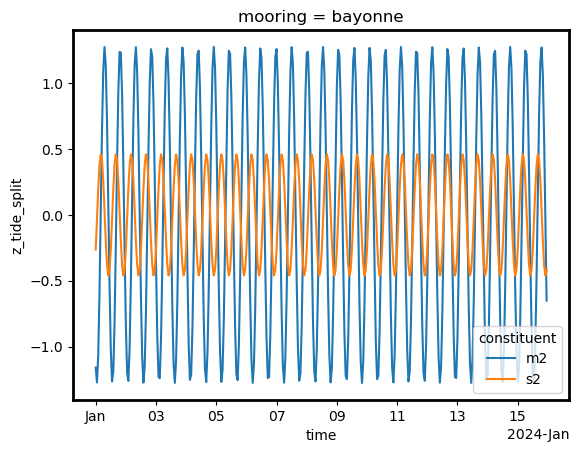

In [42]:
tlim = ("2024/01/01", "2024/01/15")
da = ds["z_tide_split"].sel(mooring="bayonne", time=slice(*tlim))
da.plot.line(hue="constituent")

### total sea level prediction

In [8]:
#prod = True
prod = False

# with full list of harmonics
nc = "meust_cable_tidal_time_series.nc"
if prod:
    #tp = td.tidal_prediction(cable_coarse.lon, cable_coarse.lat, time, vtype=["z", "load", "u", "v"], split=True)
    tp = td.tidal_prediction(cable_coarse.lon, cable_coarse.lat, time, vtype=["z", "load", "u", "v"], split=True)
    tp.to_netcdf(nc, mode="w")
else:
    tp = xr.open_dataset(nc)

In [20]:

def plot_tseries_range(ds, v, tslice=None, **kwargs):

    if tslice is not None:
        ds = ds.sel(time=slice(*tslice))
    
    fig = plt.figure(layout="constrained") # layout="constrained"
    
    gs = GridSpec(1, 5, figure=fig)
    
    ax = fig.add_subplot(gs[0, :3])
    da = ds[v]
    da.plot(x="time", ax=ax, **kwargs)
    ax.grid()
    ax.set_title(f"{v}")
    
    ax = fig.add_subplot(gs[0, -2])
    ax.plot(cable_coarse.depth, cable_coarse.position, color="k", lw=3)
    ax.set_yticklabels("")
    ax.grid()
    ax.set_title("depth")
    ax.set_xlabel("[m]")
    
    ax = fig.add_subplot(gs[0, -1])
    ax.plot(cable_coarse.angle, cable_coarse.position)
    ax.set_yticklabels("")
    ax.grid()
    ax.set_title("angle")
    ax.set_xlabel("[deg]")


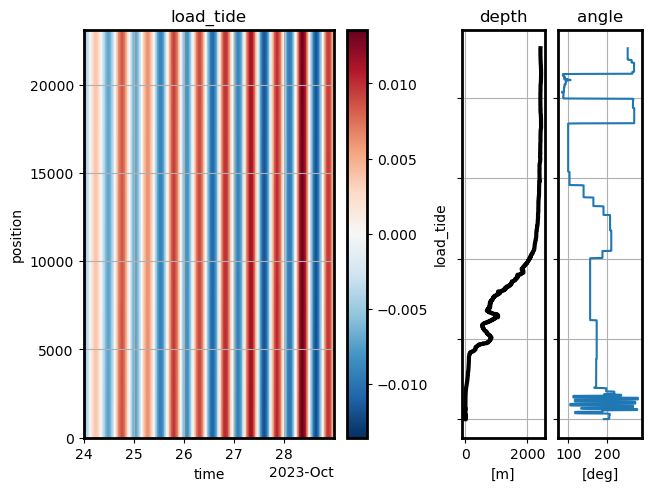

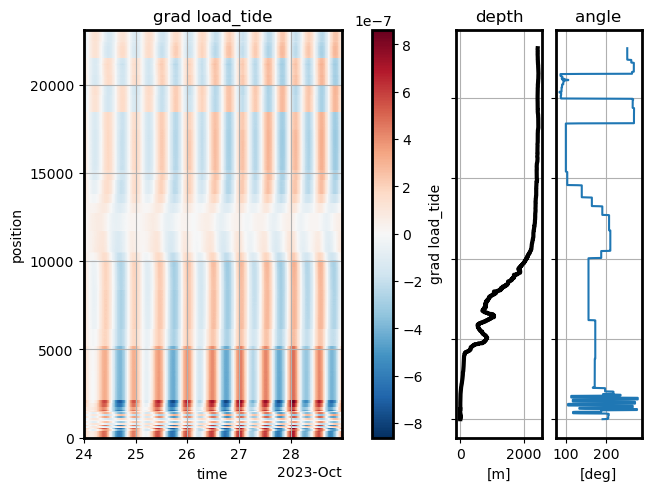

In [21]:
tslice = ("2023/10/24", "2023/10/28")

plot_tseries_range(tp, "load_tide", tslice=tslice)

tp["grad load_tide"] = tp["load_tide"].diff("position")
plot_tseries_range(tp, "grad load_tide", tslice=tslice)

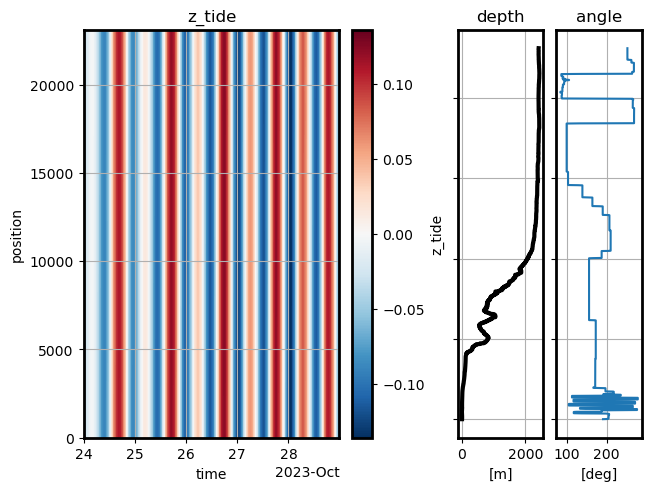

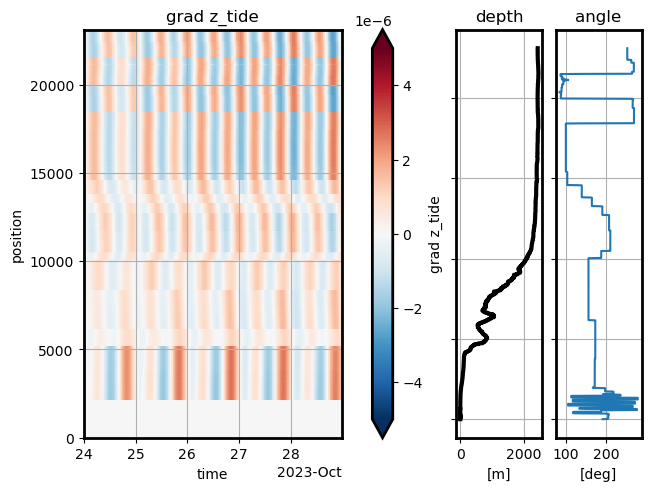

In [22]:
plot_tseries_range(tp, "z_tide", tslice=tslice)

tp["grad z_tide"] = tp["z_tide"].diff("position")
plot_tseries_range(tp, "grad z_tide", tslice=tslice, vmax=5e-6)

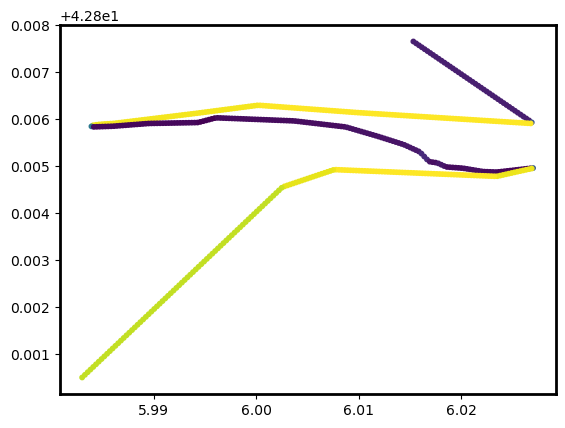

In [23]:
#fig, ax, _ = plot_map()
fig, ax = plt.subplots(1,1)
_ds = cable_coarse.sel(position=slice(18000, None))
ax.scatter(_ds.lon, _ds.lat, c=_ds.angle, s=10)

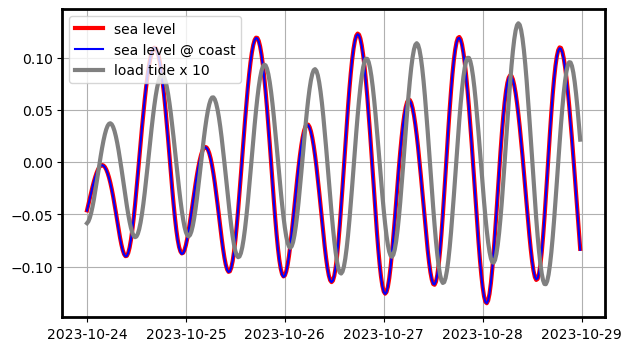

In [43]:
def plot_tseries(ds, p, tslice=None):

    if tslice is not None:
        ds = ds.sel(time=slice(*tslice))

    ds0 = ds.isel(position=0)
    
    ds = ds.sel(position=p, method="nearest")

    fig, ax = plt.subplots(1,1, figsize=(7,4))

    ax.plot(ds.time, ds.z_tide, color="r", lw=3, label="sea level")
    ax.plot(ds0.time, ds0.z_tide, color="b",  label="sea level @ coast")
    ax.plot(ds.time, ds.load_tide*10, color="0.5", lw=3, label="load tide x 10")
    #ax.plot(ds.time, ds["grad load_tide"]*1e6, color="k", lw=3, label="grad load_tide")
    #ax.plot(ds.time, ds["grad z_tide"]*1e5, color="k", label="grad z_tide")

    #ax.set_title(f"residual rms = {residual_rms*1e2:.1f} cm")
    ax.grid()
    ax.legend()

tslice = ("2023/10/24", "2023/10/28")
plot_tseries(tp, 15_000 , tslice=tslice)

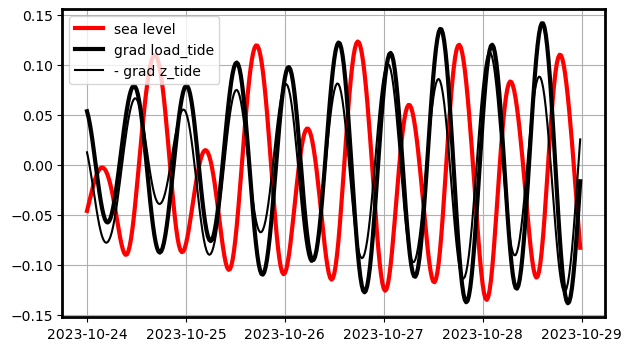

In [41]:
def plot_tseries(ds, p, tslice=None):

    if tslice is not None:
        ds = ds.sel(time=slice(*tslice))

    ds0 = ds.isel(position=0)
    
    ds = ds.sel(position=p, method="nearest")

    fig, ax = plt.subplots(1,1, figsize=(7,4))

    ax.plot(ds.time, ds.z_tide, color="r", lw=3, label="sea level")
    #ax.plot(ds0.time, ds0.z_tide, color="b",  label="sea level @ coast")
    #ax.plot(ds.time, ds.load_tide*10, color="0.5", lw=3, label="load tide")
    ax.plot(ds.time, ds["grad load_tide"]*5e5, color="k", lw=3, label="grad load_tide")
    ax.plot(ds.time, -ds["grad z_tide"]*5e4, color="k", label="- grad z_tide")

    #ax.set_title(f"residual rms = {residual_rms*1e2:.1f} cm")
    ax.grid()
    ax.legend()

tslice = ("2023/10/24", "2023/10/28")
plot_tseries(tp, 15_000 , tslice=tslice)



---

## misc: constituents, frequencies, equilibrium tides

In [5]:
td.cproperties

,amplitude,phase,omega,alpha,species,omega_cpd
constituent,,,,,,
m3,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
eps2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
n4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mtm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
msqm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
lambda2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mks2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
r2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
s4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000


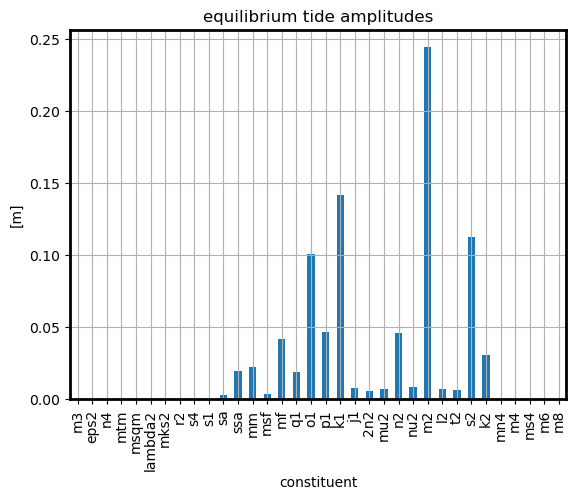

In [6]:
ax = td.cproperties.amplitude.plot.bar()
ax.set_title("equilibrium tide amplitudes")
ax.set_ylabel("[m]")
ax.grid()

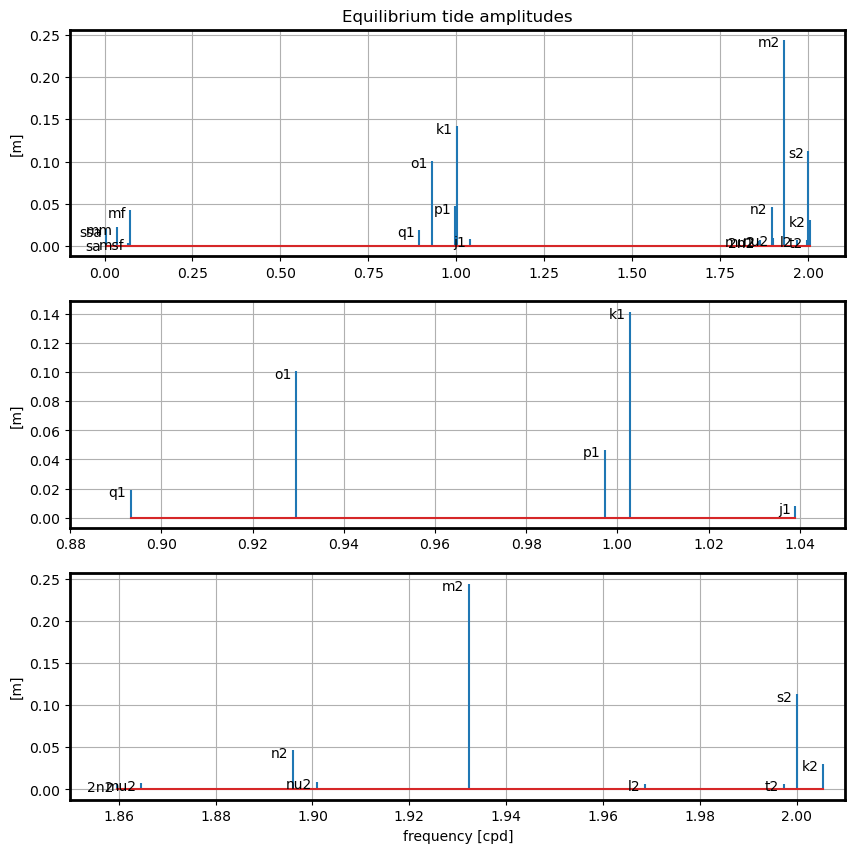

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))
td.plot_equilibrium_amplitudes(td.cproperties, axes[0])
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[1], xlim=(.88, 1.05))
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[2], xlim=(1.85, 2.01))

for i in range(0,2):
    axes[i].set_xlabel("")
for i in range(1,3):
    axes[i].set_title("")

### play with tidal arguments used for predictions

$
\begin{align}
\eta = \mathcal{R} \Big \{  \sum_k h_k \times f_k(t) h_c e^{i (g_k(t) + u_k(t) ) }  \Big \}
\end{align}
$

$g_k (t)$ is the equilibrium argument, it is common to all models
$f_l(t)$ and $u_k(t)$ are nodal corrections.


Constituents have unit complex amplitudes here:

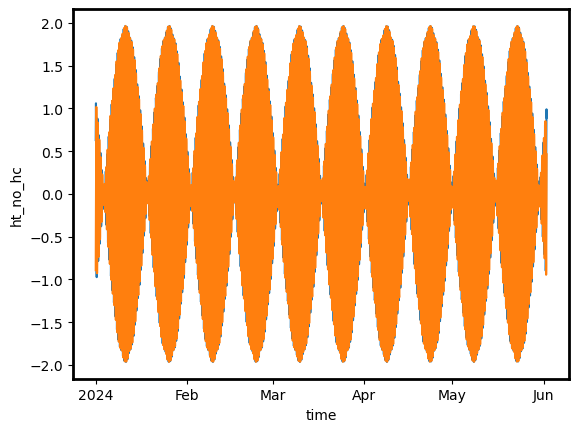

In [8]:
ds = td.get_tidal_arguments(time)

_ds = ds
#_ds = ds.isel(time=slice(0,24*28))
np.real(_ds["ht_no_hc"]).sel(constituent=td.major_semidiurnal).sum("constituent").plot()
np.imag(_ds["ht_no_hc"]).sel(constituent=td.major_semidiurnal).sum("constituent").plot()